In [2]:
# If an import error occurs try: 
# "pip install attrs==19.1.0" in the cmd
from pathlib import Path
import numpy as np
import pylab as pl
from numpy.testing.decorators import skipif
import mvpa2.suite as mvpa
from mvpa2.measures import rsa
import utility_functions as uf

In [3]:
# Wider Output
np.set_printoptions(edgeitems=20)

# Project Directory
project_dir = Path.cwd().parents[0]

# BOLD Files Directory
data_dir = project_dir.joinpath("data", "studyforrest-data-aligned")

# Anno Files Directory
anno_dir = project_dir.joinpath("data", "studyforrest-data-annotations")

# Template Directory
template_dir = project_dir.joinpath("data", "studyforrest-data-templatetransforms")

# Get Participant Files
ao_files = uf.get_files(data_dir, '*aomovie*nii.gz')
av_files = uf.get_files(data_dir, '*avmovie*nii.gz')

# Get Annotation Files
ao_anno_files = uf.get_files(anno_dir, '*emotions*ao*run*.tsv')
av_anno_files = uf.get_files(anno_dir, '*emotions*av*run*.tsv')

# Reference Space
ref = str(template_dir.joinpath("templates", "grpbold3Tp2", "brain.nii.gz"))

# Warp Files
warp_files = uf.get_files(template_dir, '*subj2tmpl_warp*.nii.gz')

# Check if all components are good to go
path_list = [project_dir, data_dir, anno_dir, template_dir, ref]
file_lists = [ao_files, av_files, ao_anno_files, av_anno_files, warp_files]

check = uf.check_all_components(path_list, file_lists)
print("{}\n".format(check[0]))
print("{}\n".format(check[1]))

All directories seem to be properly set up

All file lists seem to complete



In [6]:
# Create/Load DS
ds_save_p = Path("/home/arkani/Desktop/studyforrest_speaker_recognition/data/tmp/preprocessed_ds.hdf5")
mask = str(project_dir.joinpath("data", "speakers_association-test_z_FDR_0.01.nii.gz"))
# targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'FORRESTJR', 'BUBBA', 'DAN', 'JENNY']
targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'JENNY']

ds = uf.load_create_save_ds(ds_save_p, av_files[0:2], ref_space=ref, warp_files=warp_files,
                            mask=mask, detrending=True, use_zscore=True, use_events=True,
                            anno_dir=anno_dir, use_glm_estimates=False, targets=targets,
                            event_offset=2, event_dur=6)

print("This is the shape of the dataset: {}\n".format(ds.shape))

print("This mask file was used and if required resampled: \n{}\n".format(mask))

all_events = ds.sa.targets
unique_events = np.unique(all_events)
num_events = len(ds.sa.targets)

print("The following unique events will be included: {}".format(unique_events))
print("The number of included events amounts to: {}\n".format(num_events))

print(ds.a)
print(ds.fa)
print(ds.sa)

This is the shape of the dataset: (268, 4840)

This mask file was used and if required resampled: 
/home/arkani/Desktop/studyforrest_speaker_recognition/data/speakers_association-test_z_FDR_0.01.nii.gz

The following unique events will be included: ['FORREST' 'FORRESTVO' 'JENNY' 'MRSGUMP']
The number of included events amounts to: 268

<DatasetAttributesCollection: imgaffine,imgtype,voxel_dim,voxel_eldim>
<FeatureAttributesCollection: event_offsetidx,voxel_indices>
<SampleAttributesCollection: chunks,duration,event_onsetidx,onset,orig_duration,orig_offset,orig_onset,participant,targets,time_coords,time_indices>


In [14]:
# Normal Classifier Analysis
clf = mvpa.kNN(k=1, dfx=mvpa.one_minus_correlation, voting='majority')

#ds_split1 = ds[ds.sa.chunks == 1]
#ds_split2 = ds[ds.sa.chunks == 2]

#clf.train(ds_split1)

#predictions = clf.predict(ds_split2.samples)
#print(np.mean(predictions == ds_split2.sa.targets))

<bound method Dataset.summary of Dataset(array([[-2.93707350e-01,  3.52087393e-01,  2.50677620e-02,
        -1.58057697e-01, -9.05522148e-01, -3.35163494e-01,
        -7.35750806e-01, -4.96383866e-01, -4.90189094e-01,
        -5.47464277e-01, -5.86732158e-01, -7.95977526e-01,
        -3.09859005e-02,  5.96098653e-01, -7.39415217e-01,
         3.29896434e-01, -1.64688784e-01,  5.63967323e-02,
        -6.36858275e-01,  1.68711148e-01, ..., -3.66934972e-01,
         7.32076906e-01,  1.20528666e+00,  7.61215884e-01,
         3.27606795e-01, -2.47350957e-01,  1.46392383e+00,
         1.14923288e+00,  1.90697708e-01, -6.12413811e-01,
         1.29595116e+00,  1.84041980e+00,  1.01110128e+00,
        -2.29731056e-01,  1.16914509e+00, -1.69741732e+00,
        -9.67305701e-01, -7.57189401e-02, -1.54349904e+00,
        -1.19637592e+00],
       [-3.64806177e-01,  3.55691532e-01, -6.31910052e-01,
         3.53658794e-01,  1.25966158e-01,  2.07352832e-01,
        -1.12711454e-01, -1.11323054e+00, -

In [8]:
# Testing
clf.set_postproc(mvpa.BinaryFxNode(mvpa.mean_mismatch_error, 'targets'))
clf.train(ds)
err = clf(ds)
print(err.samples)

clf = mvpa.kNN(k=1, dfx=mvpa.one_minus_correlation, voting='majority')
cvte = mvpa.CrossValidation(clf, mvpa.HalfPartitioner(attr='chunks'))
cv_results = cvte(ds)
print(np.mean(cv_results))

cvte = mvpa.CrossValidation(clf, mvpa.HalfPartitioner(attr='chunks'),
                       errorfx=lambda p, t: np.mean(p == t))
cv_results = cvte(ds)
print(np.mean(cv_results))
print(cv_results.samples)


cvte = mvpa.CrossValidation(clf, mvpa.NFoldPartitioner(cvtype=1), 
                            errorfx=lambda p, t: np.mean(p == t),
                            enable_ca=['stats'])
# cv_results = cvte(ds)
# print(cvte.ca.stats.as_string(description=True))
# print(cvte.ca.stats.matrix)

[[0.07462687]]
0.7780225988700564
0.22197740112994352
[[0.23728814]
 [0.20666667]]


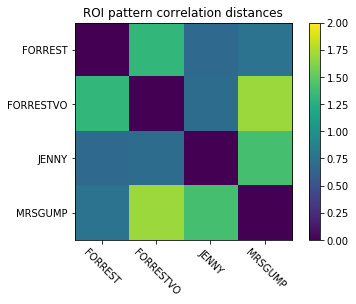

In [9]:
# RSA
mtgs = mvpa.mean_group_sample(['targets'])
mtds = mtgs(ds)
dsm = rsa.PDist(square=True)
res = dsm(mtds)

## Graphical Results
def plot_mtx(mtx, labels, title):
    pl.figure()
    pl.imshow(mtx, interpolation='nearest')
    pl.xticks(range(len(mtx)), labels, rotation=-45)
    pl.yticks(range(len(mtx)), labels)
    pl.title(title)
    pl.clim((0, 2))
    pl.colorbar()

plot_mtx(res, mtds.sa.targets, 'ROI pattern correlation distances')
pl.show()

In [9]:
## MVPA (GLM Estimates)
    # useful when: multiple concurrent signals are overlapping in time, such as in 
    # fast event-related designs
    # GLM estimates instead of raw data

# only 1 ds as input possible otherwise unstackable
# modify event dicts and stack datasets before event detection to make this work?
    
# Create Datset
mask_files = uf.get_files(project_dir, '*association*.nii.gz')
mask = mask_files[0]
# targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'FORRESTJR', 'BUBBA', 'DAN', 'JENNY']
# vstack Probleme wenn nicht in allen Runs die gleichen Targets gefunden werden?
targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'FORRESTJR', 'DAN', 'JENNY']
ds = uf.preprocess_datasets(av_files[0], ref_space=ref, warp_files=warp_files, 
                            mask=mask, detrending=True, use_zscore=True, 
                            use_events=True, anno_dir=anno_dir, use_glm_estimates=True,
                            targets=targets, event_offset=2, event_dur=6)

print("This is the Dataset that will be used in the following Analysis:")
print("{}\n".format(ds))

print("Used mask file: \n{}\n".format(mask))
print(ds.sa)
print(ds.fa)
print(ds.a)

print("\nGLM Estimates were computed for the following targets: {}\n".format(ds.sa.targets))

# cross-validation Analysis with a chosen Classifier
clf = mvpa.kNN(k=1, dfx=mvpa.one_minus_correlation, voting='majority')
cv = mvpa.CrossValidation(clf, mvpa.NFoldPartitioner(attr='chunks'))
# cv_glm = cv(ds)
# print('%.2f' % np.mean(cv_glm))

This is the Dataset that will be used in the following Analysis:
<Dataset: 4x166148@float64, <sa: regressors,targets>, <fa: voxel_indices>, <a: add_regs,imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>>

Used mask file: 
/home/arkani/Desktop/studyforrest_speaker_recognition/data/speakers_association-test_z_FDR_0.01.nii.gz

<SampleAttributesCollection: regressors,targets>
<FeatureAttributesCollection: voxel_indices>
<DatasetAttributesCollection: add_regs,imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>

GLM Estimates were computed for the following targets: ['FORREST' 'FORRESTVO' 'JENNY' 'MRSGUMP']



In [ ]:
# kürzere code lines (pylint)

# vstack Probleme
    # glm estimates erzeugen Problem
    
# mask
    # restrict mask to ROIs
    # nilearn Methode: another Mask, Überschneidung, dann Dilatation
    # wie Info aus Atlanten verwenden? 
        # ROI representations in xml files (Bsp.: "/usr/share/data/mni-structural-atlas/MNI.xml")
            # Definition des ROIs für MNI 1mm
            # wie ROI Info anpassen an Grp Space

# Tests
    # Regression Tests: 
        # 1. finaler Code: Ergebnis speichern, 
        # nach Code Änderungen gucken, ob das gleiche rauskommt
        # über mvpa.seed Zufallswert festlegen, sonst entstehen 
        # jedes mal andere Ergebnisse
    # Unit tests
        # gucken ob output in richtiger relation zu input
        # zb gleiche m x n konfusionsmatrix
    # Datenintegritätschecks
        # für argument x wirklich eine Liste / str angegeben
    
# Vorgehensweise
    # jeden einzelnen Run mit dem jeweiligen Template für die VP in den Gruppenspace
        # sind momentan alle nur innerhalb der VP aligned
    # Maske an Gruppenraum anpassen
    # Maske bearbeiten (nur Sprachareale)